In [4]:
## Plot (Isopycnal) Meridional Overturning Circulation with Python
## - started from MOC binning code by D. Sidorenko, AWI
## - T.Rackow, AWI, OCT 2018

In [5]:
import sys
sys.path.append('/mnt/lustre01/pf/a/a270046/hierarchy/pyfesom_fork') # (github)
import pyfesom as pf

import matplotlib.pylab as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
from matplotlib import cm
import copy
import xarray as xr
import pandas as pd
import seawater as sw

In [6]:
##%matplotlib inline
%matplotlib nbagg

#### Which data?

In [7]:
# LR scenario start
firstyear,lastyear=1990,1990
filetmp = '/work/ab0995/a270067/fesom_echam/core/cpl_output_02/fesom.{}.oce.mean.nc'
files = [filetmp.format(d) for d in range(firstyear,lastyear+1,1)]
LRscen_start = xr.open_mfdataset(files, chunks={'time': 12}, concat_dim='time')

# fix time axis
dates = pd.date_range('1990','1991', freq='M') #2099
LRscen_start.coords['time']=dates

In [8]:
# load mesh
meshpath  ='/work/bm0944/input/CORE2_final/' # COREII at DKRZ
mesh = pf.load_mesh(meshpath, get3d=False, usepickle=True)

/work/bm0944/input/CORE2_final/pickle_mesh
2
The usepickle == True)
The pickle file for python 2 exists.
The mesh will be loaded from /work/bm0944/input/CORE2_final/pickle_mesh


In [9]:
from collections import OrderedDict
data=OrderedDict()
data['LRscen-test']=OrderedDict()

In [10]:
# start with September 1990 data
#data['LRscen-test']['w'] = LRscen_start.w.sel(time='1990-09-30').compute()
#data['LRscen-test']['temp'] = LRscen_start.temp.sel(time='1990-09-30').compute()
#data['LRscen-test']['salt'] = LRscen_start.salt.sel(time='1990-09-30').compute()
data['LRscen-test']['w'] = LRscen_start.w.mean(dim='time').compute()
data['LRscen-test']['temp'] = LRscen_start.temp.mean(dim='time').compute()
data['LRscen-test']['salt'] = LRscen_start.salt.mean(dim='time').compute()
LRscen_start.close()

## start binning

In [11]:
#isopycnals=np.array([31., 32.,33.,34.,35.,36.,37.,38., 39.]) # sigma2
isopycnals=np.arange(28.,37.5,0.05)

In [12]:
nlats=180 #90 #180 #1800
lats=np.linspace(-89.95,89.95,nlats)
dlat=lats[1]-lats[0]

# get values needed in the computation
nlevels=np.shape(mesh.zlevs)[0]
depth=mesh.zlevs

# the triangle areas
el_area=mesh.voltri

# node indices for every element
el_nodes=mesh.elem

# mesh coordinates
nodes_x=mesh.x2 # -180 ... 180
nodes_y=mesh.y2 # -90 ... 90

# compute lon/lat coordinate of an element required later for binning
elem_x = nodes_x[el_nodes].sum(axis=1)/3.
elem_y = nodes_y[el_nodes].sum(axis=1)/3.

# number of local vertical levels for every grid point
nlevels_local=np.sum(mesh.n32[:,:]!=-999,axis=1)
hittopo_at=np.min(nlevels_local[el_nodes[:,0:3]],axis=1)-1 # hit topo at this level

# compute positions of elements in zonalmean-array for binning
pos = ((elem_y-lats[0])/dlat).astype('int')

In [13]:
# initialize additional variables
temp_insitu_ip1=np.zeros((nlevels,mesh.e2d))*np.nan
temp_insitu_i=np.zeros((nlevels,mesh.e2d))*np.nan

sigma_2_ip1=np.zeros_like(temp_insitu_ip1)*np.nan
sigma_2_i=np.zeros_like(temp_insitu_i)*np.nan

elemhit_alltime=np.zeros((mesh.e2d))
# get W on elem for all the isopycnals
elemhit=np.zeros((mesh.e2d))
W=np.zeros((mesh.e2d,isopycnals.shape[0]))*np.nan
S=np.zeros((mesh.e2d,isopycnals.shape[0]))*np.nan

In [14]:
for lev in np.arange(nlevels-1,0,-1): #45..1
    
    if lev%10==0: print lev
       
    # level i+1, bottom  at z=depth[lev] (45, 44, .. , 0:nan)
    T_ip1_tmp=pf.fesom2depth(depth[lev], data['LRscen-test']['temp'], mesh, verbose=False)
    T_ip1=np.mean(T_ip1_tmp[el_nodes[:,0:3]], axis=1) # elem-wise mean
    
    S_ip1_tmp=pf.fesom2depth(depth[lev], data['LRscen-test']['salt'], mesh, verbose=False)
    S_ip1=np.mean(S_ip1_tmp[el_nodes[:,0:3]], axis=1) # elem-wise mean
    
    W_tmp=pf.fesom2depth(depth[lev], data['LRscen-test']['w'], mesh, verbose=False)
    # (area-weighted) mean over elements
    W_elem_mean_weigh_ip1 = el_area*np.mean(W_tmp[el_nodes[:,0:3]], axis=1)*10.**-6
    W_elem_mean_weigh_ip1[hittopo_at==lev]=0. # no flow into topography
    
    # level i, top at z=depth[lev-1]    (45:nan, 44, 42, .. 0)
    T_i_tmp  =pf.fesom2depth(depth[lev-1], data['LRscen-test']['temp'], mesh, verbose=False)
    T_i =np.mean(T_i_tmp[el_nodes[:,0:3]], axis=1) # elem-wise mean
    
    S_i_tmp  =pf.fesom2depth(depth[lev-1], data['LRscen-test']['salt'], mesh, verbose=False)
    S_i =np.mean(S_i_tmp[el_nodes[:,0:3]], axis=1) # elem-wise mean
    
    W_tmp=pf.fesom2depth(depth[lev-1], data['LRscen-test']['w'], mesh, verbose=False)
    # (area-weighted) mean over elements
    W_elem_mean_weigh_i = el_area*np.mean(W_tmp[el_nodes[:,0:3]], axis=1)*10.**-6
    #W_elem_mean_weigh_i[hittopo_at==lev]=0. # no flow into topography
    
    # mask nan values
    #T_ip1=np.ma.masked_invalid(T_ip1)
    #S_ip1=np.ma.masked_invalid(S_ip1)
    #T_i  =np.ma.masked_invalid(T_i)
    #S_i  =np.ma.masked_invalid(S_i)
    
    # calculates temperature from potential temperature pt at the reference pressure pr and in situ pressure p
    temp_insitu_ip1[lev,:]=sw.eos80.temp(s=S_ip1, pt=T_ip1, p=depth[lev], pr=0.)
    temp_insitu_i[lev-1,:]=sw.eos80.temp(s=S_i, pt=T_i, p=depth[lev-1], pr=0.)
    #temp_insitu_ip1[lev,:]=np.ma.masked_array(temp_insitu_ip1[lev,:], mask=T_ip1)
    #temp_insitu_i[lev-1,:]=np.ma.masked_array(temp_insitu_i[lev-1,:], mask=T_i)
                         
    # density of Sea Water using UNESCO 1983 (EOS 80) polynomial
    sigma_2_ip1[lev,:]=sw.eos80.pden(s=S_ip1, t=temp_insitu_ip1[lev,:], p=depth[lev], pr=2000.)-1000.
    sigma_2_i[lev-1,:]=sw.eos80.pden(s=S_i, t=temp_insitu_i[lev-1,:], p=depth[lev-1], pr=2000.)-1000.
    
    
    sigm=0
    for isopycnal in isopycnals: # for every level, isopycnal only found once per elem or not
        #out[lev,:,sigm]=np.logical_and(isopycnal>=sigma_2_i[lev-1,:], isopycnal<=sigma_2_ip1[lev,:])
        elemhit=np.logical_or(  np.logical_and(isopycnal>=sigma_2_i[lev-1,:], isopycnal<=sigma_2_ip1[lev,:]),
                                np.logical_and(isopycnal<=sigma_2_i[lev-1,:], isopycnal>=sigma_2_ip1[lev,:]) )
        elemhit_alltime=elemhit_alltime+elemhit
        
        # elemhit could be zero or contain 1 hit per elem
        #if np.sum(elemhit)>0.:
            
        # INTERPOLATION    
        W[elemhit,sigm]=(W_elem_mean_weigh_i[elemhit] + W_elem_mean_weigh_ip1[elemhit])/2. # W(elem,sigm), use depth[lev] for interpolation
        S[elemhit,sigm]=(sigma_2_i[lev-1,elemhit] + sigma_2_ip1[lev,elemhit])/2. # W(elem,sigm), use depth[lev] for interpolation
        
        # next density
        sigm=sigm+1

/mnt/lustre02/work/ab0995/a270046/miniconda2-install/lib/python2.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in greater_equal
/mnt/lustre02/work/ab0995/a270046/miniconda2-install/lib/python2.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in less_equal
/mnt/lustre02/work/ab0995/a270046/miniconda2-install/lib/python2.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in less_equal
/mnt/lustre02/work/ab0995/a270046/miniconda2-install/lib/python2.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in greater_equal


40
30
20
10


In [15]:
# allocate binned array
binned=np.zeros((isopycnals.shape[0],nlats))*np.nan

# for every sigma
sigm=0
for isopycnal in isopycnals: # for lev ...

    # for every bin, select elements that lie within the bin and sum them
    for bins in range(pos.min(), pos.max()+1):

        # zonal band at this position & enough levels present
        indices=np.logical_and(pos==bins, True) # what to do here?, lev<=hittopo_at)
        if np.sum(indices)==0.: 
            binned[sigm, bins]=np.nan # only topo
        else:
            binned[sigm, bins]=np.nansum(W[indices, sigm], axis=0)
            
    sigm=sigm+1

In [16]:
# the result from the previous step needs to be cumulatively summed 
binned = np.ma.cumsum(np.ma.masked_invalid(binned), axis=1)

#### Northern Hemisphere still suffers from some issue:

<IPython.core.display.Javascript object>


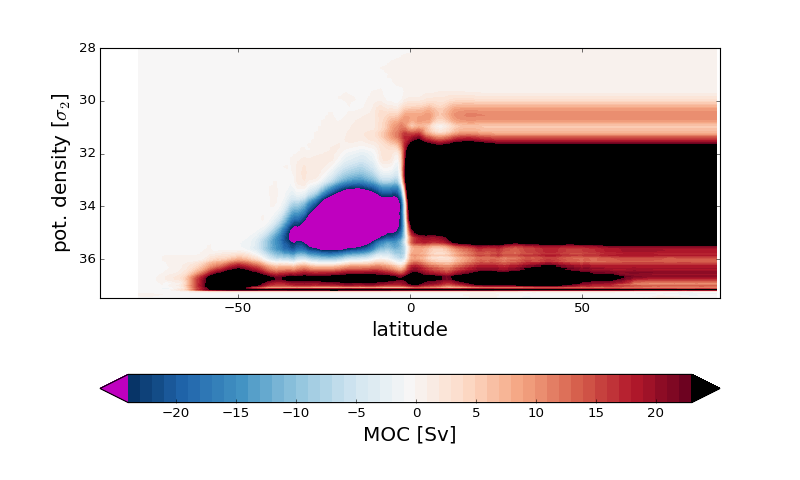

In [22]:
# plot the result
fontsize=18
cbartext='MOC [Sv]'
#cmap=cm.bwr #RdBu_r
cmap = cm.RdBu_r
cmap.set_over('k', 1.0)
cmap.set_under('m', 1.0)
#cmap.set_bad('k', 1.0)

fig = plt.figure(figsize=(10,6))
plt.contourf(lats, isopycnals, binned, cmap=cmap, levels=np.arange(-24.,24.,1.), extend='both') #np.array([-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,-0.25,0.25,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.xlabel('latitude', fontsize=fontsize)
plt.ylabel('pot. density [$\sigma_2$]', fontsize=fontsize)
cbar=plt.colorbar(orientation="horizontal", pad=.2)
#cbar.set_ticks([-75,-60,-45,0,45,60,75])
cbar.set_label(cbartext, fontsize=fontsize)  
plt.gca().invert_yaxis()

In [21]:
plt.imshow(binned)
plt.show()

In [20]:
#from mpl_toolkits.basemap import Basemap

<IPython.core.display.Javascript object>


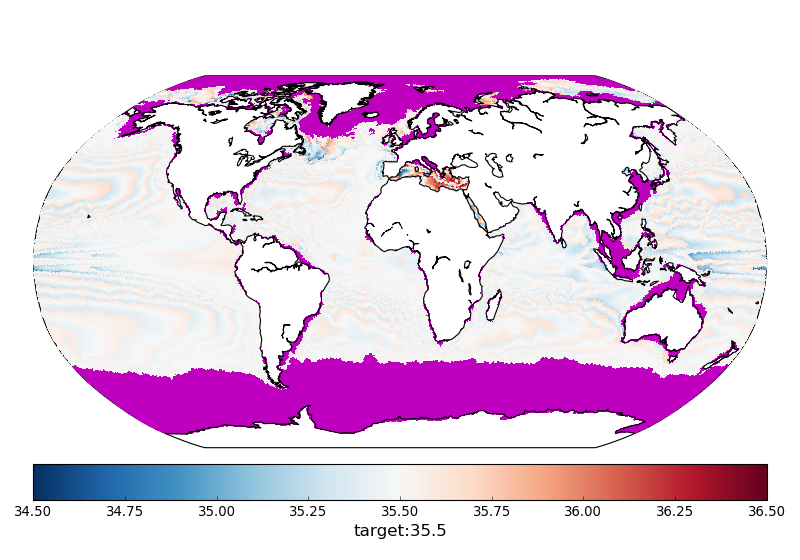

In [98]:
# what is happening?
elem2=mesh.elem[mesh.no_cyclic_elem,:]
#plotfield=np.nansum(W[:,:], axis=1)
#plotfield=temp_insitu_ip1[0,:]
#plotfield=sigma_2_ip1[0,:]
#plotfield=T_ip1[:]
#plotfield=S_ip1[:]
#plotfield=W_elem_mean_weigh_ip1[:]
#plotfield=T_i[:]
#plotfield=S_i[:]
#plotfield=W_elem_mean_weigh_i[:]
#plotfield=temp_insitu_i[45,:] # 0 okay, 45 nan
#plotfield=temp_insitu_ip1[20,:] # 0 nan, 45 still has some values
#plotfield=sigma_2_i[45,:] # 0 okay, 45 nan
#plotfield=sigma_2_ip1[1,:] # 0 nan, 45 still values
#plotfield=elemhit_alltime
i=150 #20;63;90 0..99
plotfield=S[:,i]

# Tip1
#vmin=-2.
#vmax=30.
# Sip1
#vmin=28.
#vmax=37.
# Wip1
#vmin=-5.e-3
#vmax=5.e-3
# sigma_2_i for testing interpolation!!
vmin=isopycnals[i]-1.
vmax=isopycnals[i]+1.


#steps = 50
#plt.figure(figsize=(10,7))
#-- plot
fig=plt.figure(figsize=(10,7))
map = Basemap(projection='robin',lon_0=0, resolution='c')
x, y = map(mesh.x2, mesh.y2)

map.drawmapboundary()
map.drawcoastlines()
mm = plt.tripcolor(x, y, elem2, plotfield[mesh.no_cyclic_elem], edgecolors='none', cmap=cmap, vmin = vmin, vmax = vmax)
#desc="W"
cbartext = 'target:'+str(isopycnals[i])
cb = plt.colorbar(mm, orientation = 'horizontal', pad = 0.03)
cb.ax.set_xlabel(cbartext, size = 15)
#plt.title(desc, size = 35)
plt.tight_layout()

<IPython.core.display.Javascript object>


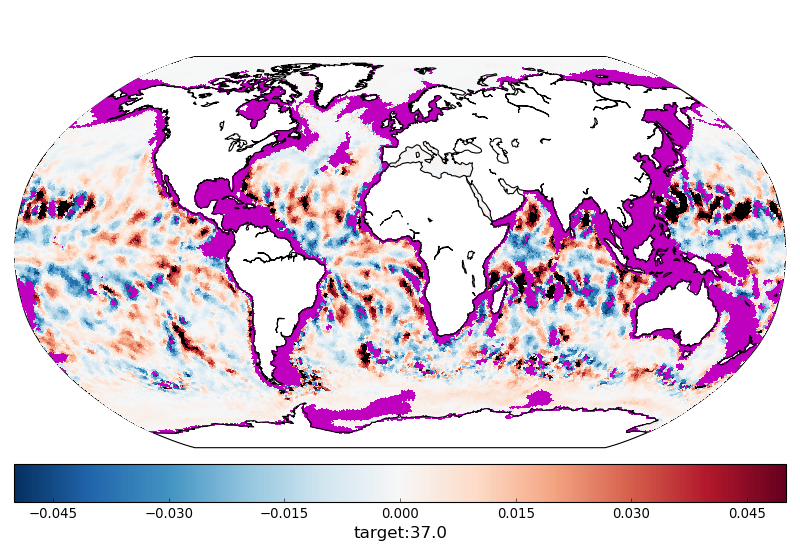

In [101]:
# what is happening?
elem2=mesh.elem[mesh.no_cyclic_elem,:]
#plotfield=np.nansum(W[:,:], axis=1)
#plotfield=temp_insitu_ip1[0,:]
#plotfield=sigma_2_ip1[0,:]
#plotfield=T_ip1[:]
#plotfield=S_ip1[:]
#plotfield=W_elem_mean_weigh_ip1[:]
#plotfield=T_i[:]
#plotfield=S_i[:]
#plotfield=W_elem_mean_weigh_i[:]
#plotfield=temp_insitu_i[45,:] # 0 okay, 45 nan
#plotfield=temp_insitu_ip1[20,:] # 0 nan, 45 still has some values
#plotfield=sigma_2_i[45,:] # 0 okay, 45 nan
#plotfield=sigma_2_ip1[1,:] # 0 nan, 45 still values
#plotfield=elemhit_alltime
i=180 #20;63;90 0..99
plotfield=W[:,i]

# Tip1
#vmin=-2.
#vmax=30.
# Sip1
#vmin=28.
#vmax=37.
# Wip1
vmin=-5.e-2
vmax=5.e-2
# sigma_2_i for testing interpolation!!
#vmin=isopycnals[i]-1.
#vmax=isopycnals[i]+1.


#steps = 50
#plt.figure(figsize=(10,7))
#-- plot
fig=plt.figure(figsize=(10,7))
map = Basemap(projection='robin',lon_0=0, resolution='c')
x, y = map(mesh.x2, mesh.y2)

map.drawmapboundary()
map.drawcoastlines()
mm = plt.tripcolor(x, y, elem2, plotfield[mesh.no_cyclic_elem], edgecolors='none', cmap=cmap, vmin = vmin, vmax = vmax)
#desc="W"
cbartext = 'target:'+str(isopycnals[i])
cb = plt.colorbar(mm, orientation = 'horizontal', pad = 0.03)
cb.ax.set_xlabel(cbartext, size = 15)
#plt.title(desc, size = 35)
plt.tight_layout()

In [100]:
isopycnals.shape

(190,)

For depth 0.0 model level -0.0 will be used


<IPython.core.display.Javascript object>


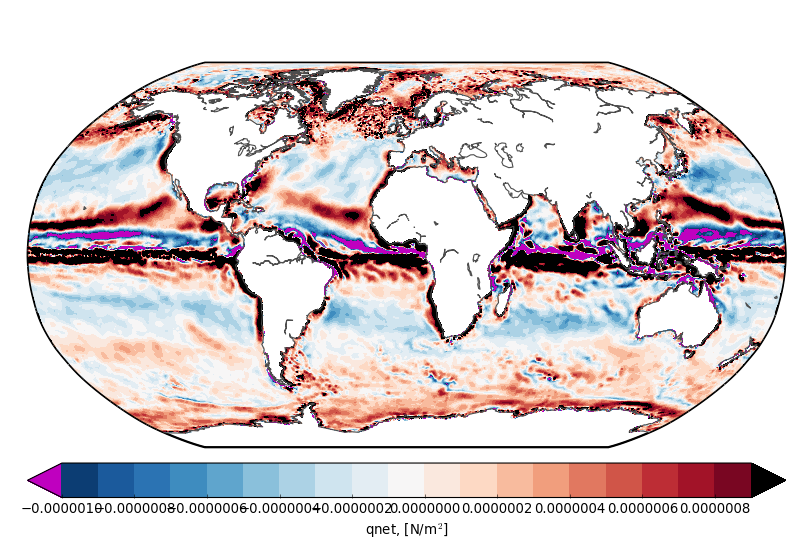

In [151]:
# get data at level
depth=0. #-- surface value
level_data, elem_no_nan = pf.get_data(W_tmp, mesh, depth) #T_ip1_tmp

#-- plot
fig=plt.figure(figsize=(10,7))
map = Basemap(projection='robin',lon_0=0, resolution='c')
x, y = map(mesh.x2, mesh.y2)
levels = np.arange(32, 39, .05) #-- contour levels for salt
#levels = np.arange(-20., 20.+1, 1.) #-- contour levels for temp
levels = np.arange(-10**(-6), 10**(-6), 10**(-7)) #-- contour levels for windstress
plt.tricontourf(x, y, elem_no_nan[::], level_data, levels=levels, cmap=cmap, extend='both') #cmap_correlations256

#-- draw grey coastlines and thick black outline
map.drawcoastlines(linewidth=1.0, linestyle='solid', color='0.3', antialiased=1)
map.drawmapboundary(linewidth=2.0, color='black')
cbar = plt.colorbar(orientation='horizontal', pad=0.03);
cbar.set_label("qnet, [N/m$^2$]")
#plt.title('DJF: climate change signal from scenario run')
plt.tight_layout()
plt.show()

In [109]:
plot all steps (2d) as a map to see what happens!! plot T along sigm as test??

(90,)

<IPython.core.display.Javascript object>


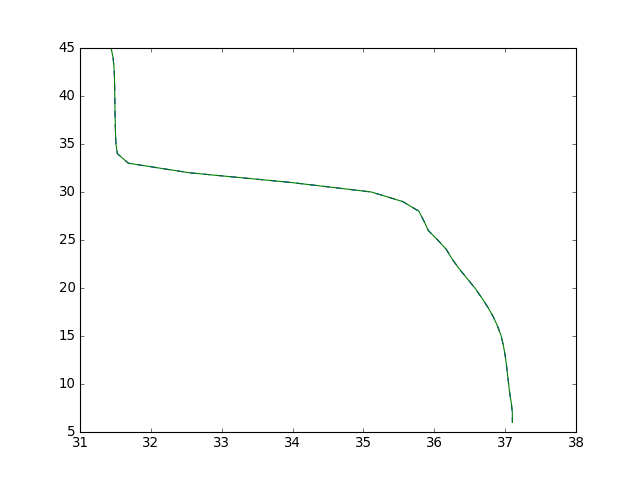

In [106]:
plt.plot(sigma_2_ip1[:,14650],np.arange(nlevels-1,0-1,-1), linestyle='dashed') # 45..0
plt.plot(sigma_2_i[:,14650], np.arange(nlevels-1,0-1,-1)) # 45..0

In [ ]:
1) integrate v from bottom to z, with z variable:
     V(x,y,z,t) = integral{bottom to z} dz' v(x,y,z',t);
2) regrid (1) to density coordinates;
3) zonally integrate (2).

### working zlevel code:

In [ ]:
nlats=180 #90 #180 #1800
lats=np.linspace(-89.95,89.95,nlats)
dlat=lats[1]-lats[0]

In [ ]:
# get values needed in the computation
nlevels=np.shape(mesh.zlevs)[0]
depth=mesh.zlevs

# the triangle areas
el_area=mesh.voltri

# node indices for every element
el_nodes=mesh.elem

# mesh coordinates
nodes_x=mesh.x2 # -180 ... 180
nodes_y=mesh.y2 # -90 ... 90

# compute lon/lat coordinate of an element required later for binning
elem_x = nodes_x[el_nodes].sum(axis=1)/3.
elem_y = nodes_y[el_nodes].sum(axis=1)/3.

# number of local vertical levels for every grid point
nlevels_local=np.sum(mesh.n32[:,:]!=-999,axis=1)
hittopo_at=np.min(nlevels_local[el_nodes[:,0:3]],axis=1)-1 # hit topo at this level

# compute positions of elements in zonalmean-array for binning
pos = ((elem_y-lats[0])/dlat).astype('int')

In [ ]:
# allocate binned array
binned=np.zeros((nlevels,nlats))*np.nan

for lev in range(nlevels):
        
    W=pf.fesom2depth(depth[lev], data['LRscen-test']['w'], mesh, verbose=False) # returns nan
    
    # (area-weighted) mean over elements
    W_elem_mean_weigh = el_area*np.mean(W[el_nodes[:,0:3]], axis=1)*10.**-6
    W_elem_mean_weigh[hittopo_at]=0. # no flow into topography
    
    # for every bin, select elements that lie within the bin and sum them
    for bins in range(pos.min(), pos.max()+1):

        # zonal band at this position & enough levels present
        indices=np.logical_and(pos==bins, lev<=hittopo_at)
        if np.sum(indices)==0.: 
            binned[lev, bins]=np.nan # only topo
        else:
            binned[lev, bins]=np.nansum(W_elem_mean_weigh[indices])

In [ ]:
# the result from the previous step needs to be cumulatively summed 
binned = np.ma.cumsum(np.ma.masked_invalid(binned), axis=1)

In [ ]:
# plot the result
fontsize=18
cbartext='MOC [Sv]'
#cmap=cm.bwr #RdBu_r
cmap = cm.RdBu_r
cmap.set_over('k', 1.0)
cmap.set_under('m', 1.0)
#cmap.set_bad('k', 1.0)

fig = plt.figure(figsize=(10,6))
plt.contourf(lats, -depth, binned, cmap=cmap, levels=np.arange(-24.,25.,2.), extend='both') #np.array([-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,-0.25,0.25,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
plt.xlabel('latitude', fontsize=fontsize)
plt.ylabel('depth [m]', fontsize=fontsize)
cbar=plt.colorbar(orientation="horizontal", pad=.2)
#cbar.set_ticks([-75,-60,-45,0,45,60,75])
cbar.set_label(cbartext, fontsize=fontsize)  

In [ ]:
saveFIG=True
if saveFIG==True:
   pp = PdfPages('/pf/a/a270046/LRvsHR/figures/'+'MOCtest.pdf')
   pp.savefig(fig,bbox_inches = 'tight')
   pp.close()

#### Dimas codes:

In [ ]:
# set the paths to the results, runid, etc.
result_path ='/work/ollie/dsidoren/awicm-2.0/CONTROL_1850_w_fesom_spinup/outdata/fesom/'
runid ='fesom'

# set the label for the colorbar & contour intervals for ftriplot
cbartext, cont = 'Sv', [-15., 15., .5]

# define a descrete set of latitudes
nlats=91
lats=np.linspace(-90, 90, nlats)
dlat=lats[1]-lats[0]
# allocate moc array
moc=np.zeros([mesh.nlev, nlats])

# read the required metadata (mesh diagnostic file is always created at the cold start)
# grid information is needed for computing the MOC
ncfile  = Dataset(os.path.join(result_path, runid+'.mesh.diag.nc'))
el_area =ncfile.variables['elem_area'][:]
nlevels =ncfile.variables['nlevels'][:]-1
el_nodes=ncfile.variables['elem'][:,:]-1
nodes_x =ncfile.variables['nodes'][0,:]*180./np.pi
nodes_y =ncfile.variables['nodes'][1,:]*180./np.pi

# compute lon/lat coordinate of an element required lated for binning
elem_x  =nodes_x[el_nodes].sum(axis=0)/3.
elem_y  =nodes_y[el_nodes].sum(axis=0)/3.

# specify records and year to read
records, year=np.linspace(0,0,1).astype(int), 2069

# compute MOC
# precompute positions of elements for binning
pos = ((elem_y-lats[0])/dlat).astype('int')

# compute contributions from vertical velocities on elements and put them into bins
for i in range(mesh.nlev):
# read the model result from fesom.XXXX.oce.nc
   w=read_fesom_slice('w', records, year, mesh, result_path, runid, ilev=i)
#     print(i)
   # mean over elements
   elem_mean = np.sum(w[el_nodes[:,:]], axis=0)/3.*1.e-6
   # weigh by element area
   elem_mean_weigh = el_area*elem_mean
   # select nodes to consider in calculation based on number of levels
   toproc = np.where(i <=  nlevels-1)[0]
   # for every bin select elements that belong to the bin and sum them.
   for k in range(pos.min(), pos.max()+1):
#         if (i <= nlevels[e]-1):
           moc[i, k]=elem_mean_weigh[toproc][pos[toproc]==k].sum()

# the result from the previous step needs to be cumulatively summed 
moc = np.ma.cumsum(np.ma.masked_invalid(moc), axis=1)
#moc_bolus=moc
#moc=moc+moc_bolus
# plot the result
cmap=cmo.balance
fig = plt.figure(figsize=(10,6))
plt.contourf(lats, mesh.zlev, moc, cmap=cmap, levels=np.linspace(cont[0], cont[1], 50), extend='both')
plt.xlabel('latitude, [degree]', fontsize=fontsize)
plt.ylabel('depth, [m]', fontsize=fontsize)
cbar=plt.colorbar(orientation="horizontal", pad=.2)
cbar.set_ticks([round(i,4) for i in np.linspace(cont[0], cont[1], 5)])
cbar.set_label(cbartext, fontsize=fontsize)
cbar.set_label(cbartext, fontsize=fontsize)  

In [ ]:
subroutine compute_moc
  implicit none
  integer                                    :: i, n2, n3, el, pos, lev
  integer                                    :: elnodes(3), elnode3(3)
  real(kind=8), dimension(:),   allocatable  :: oce_fld
  real(kind=8), dimension(:,:), allocatable  :: reg_fld
  real(kind=8)             	             :: x, y, vol

  zmoc=0.
  zmoc_topo=.false.
  do el=1, elem2D
     elnodes=elem2D_nodes(:, el)
     
      if (rotated_grid) then
       call r2g(x, y, sum(coord_nod2D(1, elnodes))/3., sum(coord_nod2D(2, elnodes))/3.)
      else
         x=sum(coord_nod2D(1, elnodes))/3.
         y=sum(coord_nod2D(2, elnodes))/3.
      end if

     vol=voltriangle(el)
     ! assume that reg_lat is sorted monotonically
     do i=1, reg_ny
        if (reg_lat(i) > y) then
           pos=i
           exit
        end if
     end do
     ! MOC without accumulation
     do lev=1, max_num_layers
        elnode3=nod3D_below_nod2D(lev, elnodes)
        if (all(elnode3 > 0)) then
           zmoc(pos, lev)=zmoc(pos, lev)+vol*sum(wvel(elnode3)*real(mask_n2(elnodes)))/3.*1.e-6
           zmoc_topo(pos, lev)=.true.
        end if
     end do
  end do
!full MOC
  if (use_mask) then
     do i=reg_ny-1, 1, -1
        zmoc(i, :)=-zmoc(i, :)+zmoc(i+1, :)
     end do
  else
     do i=2, reg_ny
        zmoc(i, :)=zmoc(i, :)+zmoc(i-1, :)
     end do
  end if

  where (.not. zmoc_topo)
        zmoc=0.
  end where

end subroutine compute_moc